# PER Dueling DDQNQ

The agent samples experience tuples from the replay memory uniformly at random. Intuitively, this seems like an inferior way of replaying experiences. The idea is that if an agent can remember a rare experience, it can learn more effectively from it. Prioritized experience replay is a method that prioritizes which experiences to replay based on their TD error. The TD error indicates how ‘surprising’ a certain experience is.

All the methods are the same of Dueling DDQN, the difference is in the Replay Memory implementation and in the optimization function.

In [54]:
from collections import deque

class ReplayMemory():
    def __init__(self, memory_size, batch_size):
        self.memory_size = memory_size
        self.batch_size = batch_size

        self.states = deque(maxlen=memory_size)
        self.actions = deque(maxlen=memory_size)
        self.rewards = deque(maxlen=memory_size)
        self.next_states = deque(maxlen=memory_size)
        self.is_failures = deque(maxlen=memory_size)

        self.priorities = deque(maxlen=memory_size)
        
        self.n_entries = 0
        self.next_index = 0

        self.alpha = 0.6 
        self.beta = 0.4

    def store(self, state, action, reward, next_state, is_failure):
        
        # calculate the priority for the sample using
        # the highest magnitude TD error in the memory
        priority = 1.0
        if self.n_entries > 0:
            priority = self.priorities.max()
            
        # insert the sample and its priority into the memory
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.is_failures.append(is_failure)
        self.priorities.append(priority)
    
    def update(self, idxs, td_errors):
        # takes the array of experiences ids, and new TD error values
        # insert the absolute TD errors into the right place.
        np.array(self.priorities)[idxs] = np.abs(td_errors)


    def sample(self, batch_size=None):

        batch_size = self.batch_size if batch_size == None else batch_size
        if(batch_size > self.len()): raise Exception("Batch size is greater than the memory size")
      
        # calculate priorities: the absolute TD error plus a small constant 
        # to avoid zero priorities
        priorities = np.array(self.priorities) + 1e-6
        
        # go from priorities to probabilities
        scaled_priorities = priorities ** self.alpha        
        probs = scaled_priorities / np.sum(scaled_priorities)
        
        # calculate the importance-sampling weights using the probabilities
        weights = (self.len() * probs) ** -self.beta
        weights = weights/weights.max()

        # sample experiences in the memory using the probabilities
        idxs = np.random.choice(len(self.states), batch_size, replace=False, p=probs)

        weights = np.array(weights)[idxs]
        states = np.array(self.states)[idxs]
        actions = np.array(self.actions)[idxs]
        rewards = np.array(self.rewards)[idxs]
        next_states = np.array(self.next_states)[idxs]
        is_failures = np.array(self.is_failures)[idxs]

        return idxs, weights, states, actions, rewards, next_states, is_failures

    def len(self):
        return len(self.states)

In [55]:
import torch

class Approximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Approximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)
        
        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))

        # finally, we build the two output layers, both connected to the last hidden layer 

        # the value_output has a single node output 
        self.value_output = torch.nn.Linear(128, 1)
       
        # the advantage_output has output_dim nodes
        self.advantage_output = torch.nn.Linear(128, action_size)
        
        # decide the device to be used for training
        device = "cpu"
        if torch.cuda.is_available(): device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # then pass for the advantage_output and the value_output layers. 
        a_values = self.advantage_output(x)
        v_values = self.value_output(x)
        
        # finally, add v and a and subtract the mean of a from it
        q_values = v_values + (a_values - a_values.mean())
        
        return q_values

    def select_action(self, state):
        with torch.no_grad():
            q_values = self(state).detach().data.numpy().squeeze()
        return np.argmax(q_values)

These importance-sampling weights are used in the loss function. Instead of using the TD errors straight in the gradient updates, we multiply them by the importance-sampling weights: 

In [56]:
def optimize(memory, online_model, target_model, optimizer, gamma):

    # sample a mini batch of transition from the replay buffer
    idxs, weights, states, actions, rewards, next_states, is_failures = memory.sample()

    weights = torch.from_numpy(np.vstack(weights))
    states = torch.from_numpy(np.vstack(states)).float()
    actions = torch.from_numpy(np.vstack(actions)).long()
    next_states = torch.from_numpy(np.vstack(next_states)).float()
    rewards = torch.from_numpy(np.vstack(rewards)).float().float()
    is_failures = torch.from_numpy(np.vstack(is_failures)).long()
        
    # get the best action for the next state from the online model 
    q_online_next = online_model(next_states).detach()
    argmax_q_online_next = q_online_next.max(1)[1].unsqueeze(1)

    # get the values of that action from the target model
    q_target_next = target_model(next_states).detach()
    max_q_target_next = q_target_next.gather(1, argmax_q_online_next)
    max_q_target_next *= (1 - is_failures)

    # calculate the target 
    target = rewards + gamma * max_q_target_next

    # finally, we get the current estimate of Q(s,a), here we query the current "online" network
    q_online_current = online_model(states).gather(1, actions)
    
    # create the errors
    td_errors = target - q_online_current

    # calculate the loss, and optimize the online network
    # now the loss function has TD errors downscaled by the weights
    value_loss = (weights * td_errors).pow(2).mul(0.5).mean()

    optimizer.zero_grad()
    value_loss.backward()
    optimizer.step()

    # update the priorities of the replayed batch using the absolute TD errors
    priorities = np.abs(td_errors.detach().numpy())
    memory.update(idxs, priorities.squeeze())

In [57]:
def update(target_model, online_model, tau=0.2):  
        
    for target, online in zip(target_model.parameters(), online_model.parameters()):
        # calculate the ratios we’re taking from the target and online weights
        target_ratio = (1.0 - tau) * target.data
        online_ratio = tau * online.data
        
        # mix the weights and copy the new values into the target network 
        mixed_weights = target_ratio + online_ratio
        target.data.copy_(mixed_weights)

In [58]:
def decay_epsilon(max, min, decay_episodes, max_episodes):
    rem_episodes = max_episodes - decay_episodes
    values = np.logspace(start=0, stop=-2, num=decay_episodes, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (max - min) * values + min
    values = np.pad(values, (0, rem_episodes), 'edge')
    return values

In [59]:
def epsilon_greedy(approximator, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size)
    return approximator.select_action(state)

In [60]:
def greedy(approximator, state):
    return approximator.select_action(state)

In [61]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = greedy(approximator, state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

We can now implement the full PER Dueling DDQN algorithm, which is the same of Dueling DDQN, but with the new replay buffer and optimize method:

In [62]:
import time
import numpy as np
import random
from itertools import count

import gymnasium

def per_dueling_ddqn(env_name, seed, replay_memory_size, batch_size, 
        online_optimize_steps, target_update_steps, 
        epsilon_max, epsilon_min, decay_episodes,
        gamma, max_episodes, max_time, max_score, episodes_window):
    
    # create the environment
    env = gymnasium.make(env_name)

    # create the experience replay 
    replay_buffer = ReplayMemory(replay_memory_size, batch_size)

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # create the online and target models
    online_model = Approximator(state_size, action_size)
    target_model = Approximator(state_size, action_size)
    
    # create the optimizer
    optimizer = torch.optim.RMSprop(online_model.parameters(), lr=0.0005)

    # calculate the decay epsilon
    epsilons = decay_epsilon(epsilon_max, epsilon_min, decay_episodes, max_episodes+1)
    
    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []     

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan   
        
    # synchronize the online and target models at the beginning of training
    update(target_model, online_model)
                    
    # train until we reach the terminal condition (max episodes)
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()
        
        # set return to 0
        discounted_return = 0

        # reset the environment before starting the episode
        state = env.reset()[0]

        # interact with the environment until the episode is done
        for step in count():

            # select the action using the exploration policy
            action = epsilon_greedy(online_model, state, action_size, epsilons[episode])

            # perform the selected action
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # store the experience into the replay buffer
            replay_buffer.store(state, action, reward, next_state, is_failure)
                
            # sometimes, optimize the online model using the replay buffer
            if step % online_optimize_steps == 0 and replay_buffer.len() > batch_size:
                optimize(replay_buffer, online_model, target_model, optimizer, gamma)
                 
            # sometimes, synchronize the target model with the online model
            if step % target_update_steps == 0:
                update(target_model, online_model)
                
            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            if is_done:
                break

        # evaluate the learned policy after the episode
        update(target_model, online_model)
        score = evaluate(online_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed  
            
        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time
            
        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)
            
        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
        
    return online_model, score, results

We can apply PER Dueling DDQN to the cart-pole environment using the same hyperparameters of DDQN and the experiment method:

In [63]:
class Experiment():
    def __init__(self, env_name, gamma, 
                 epsilon_max, epsilon_min, decay_episodes,
                 max_episodes, max_time, max_score, episodes_window,
                 replay_memory_size, batch_size, 
                 online_optimize_steps, target_update_steps, 
                 seeds):
        
        self.env_name = env_name
        self.gamma = gamma
        
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.decay_episodes = decay_episodes
        
        self.max_episodes = max_episodes
        self.max_time = max_time
        self.max_score = max_score
        self.episodes_window = episodes_window
        
        self.replay_memory_size = replay_memory_size
        self.batch_size = batch_size
        self.online_optimize_steps = online_optimize_steps
        self.target_update_steps = target_update_steps
        
        self.seeds =seeds
        
    def run(self, algorithm):

        # variables to collect results
        results = []
        best_agent = None
        best_eval_score = float('-inf')
    
        for seed in self.seeds:
    
            # create the agent
            agent, score, result = algorithm(self.env_name, seed, self.replay_memory_size, 
                                             self.batch_size, self.online_optimize_steps, self.target_update_steps,
                                             self.epsilon_max, self.epsilon_min, self.decay_episodes,
                                             self.gamma, self.max_episodes, self.max_time, self.max_score, self.episodes_window)

            # save the results the best agent
            results.append(result)
            if score > best_eval_score:
                best_eval_score = score
                best_agent = agent

        return np.array(results), best_agent, best_eval_score

In [64]:
experiment = Experiment(env_name='CartPole-v1', 
                        gamma=0.99,
                        epsilon_max = 1,
                        epsilon_min = 0.3,
                        decay_episodes = 800,
                        max_episodes = 1000,
                        max_time = 10*60,
                        max_score = 400,
                        episodes_window = 50,
                        replay_memory_size = 1024,
                        batch_size = 32,
                        online_optimize_steps = 1,
                        target_update_steps = 10,
                        seeds = (15, 39, 12, 45, 65))

In [65]:
experiment.target_update_steps = 1
per_dueling_ddqn_results, per_dueling_ddqn_agent, per_dueling_ddqn_score = experiment.run(per_dueling_ddqn)

episode 0272, steps 022404, average score 402.9  --> reached_max_score 
episode 0326, steps 034289, average score 401.7  --> reached_max_score 
episode 0222, steps 016165, average score 401.6  --> reached_max_score 
episode 0341, steps 033956, average score 405.2  --> reached_max_score 
episode 0177, steps 009899, average score 402.0  --> reached_max_score 


We can save the result to future comparison:

In [66]:
np.save('./saved/per_dueling_ddqn_results', per_dueling_ddqn_results)

We can load the result of DQN in order to compare the performances of the two algorithms:

In [67]:
dqn_results = np.load('./saved/dqn_results.npy')

We can plot the training reward:

In [68]:
import matplotlib.pyplot as plt

def show_result(what, alg_a_name, alg_a_results, alg_b_name, alg_b_results):

    plt.figure(figsize=(12,6))
    
    # steps, train_reward,  eval_score,  time
    alg_a_max  = np.max(alg_a_results, axis=0).T
    alg_a_min  = np.min(alg_a_results, axis=0).T
    alg_a_mean = np.mean(alg_a_results, axis=0).T
    alg_a_episodes = np.arange(len(alg_a_mean[0]))

    alg_b_max  = np.max(alg_b_results, axis=0).T
    alg_b_min  = np.min(alg_b_results, axis=0).T
    alg_b_mean = np.mean(alg_b_results, axis=0).T
    alg_b_episodes = np.arange(len(alg_b_mean[0]))

    if (what == 'total_steps'):
        index = 0;
        title = 'Total Steps'
        label = 'Steps'
    elif(what == 'avg_training_reward'):
        index = 1;
        title = 'Moving Avg Reward (Training)'
        label = 'Reward'
    elif(what == 'avg_evaluation_reward'):
        index = 2;
        title = 'Moving Avg Reward (Evaluation)'
        label = 'Reward'
    elif(what == 'training_time'):
        index = 3;
        title = 'Trainning time)'
        label = 'Time'
    else:
        raise ValueError('Not sure what you want to plot')

    plt.plot(alg_a_max[index], 'b', linewidth=1, label=alg_a_name)
    plt.plot(alg_a_min[index], 'b', linewidth=1)
    plt.plot(alg_a_mean[index], 'b', linewidth=1)
    plt.fill_between(alg_a_episodes, alg_a_min[index], alg_a_max[index], facecolor='b', alpha=0.3)

    plt.plot(alg_b_max[index], 'g', linewidth=1, label=alg_b_name)
    plt.plot(alg_b_min[index], 'g', linewidth=1)
    plt.plot(alg_b_mean[index], 'g', linewidth=1)
    plt.fill_between(alg_b_episodes, alg_b_min[index], alg_b_max[index], facecolor='g', alpha=0.3)

    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Episodes')
    plt.legend()

    plt.show()

The most obvious conclusion we can draw is that DDQN is more sample efficient than DQN. It takes less episodes to reach the same reward. This is because DDQN is less prone to overestimation of Q-values.

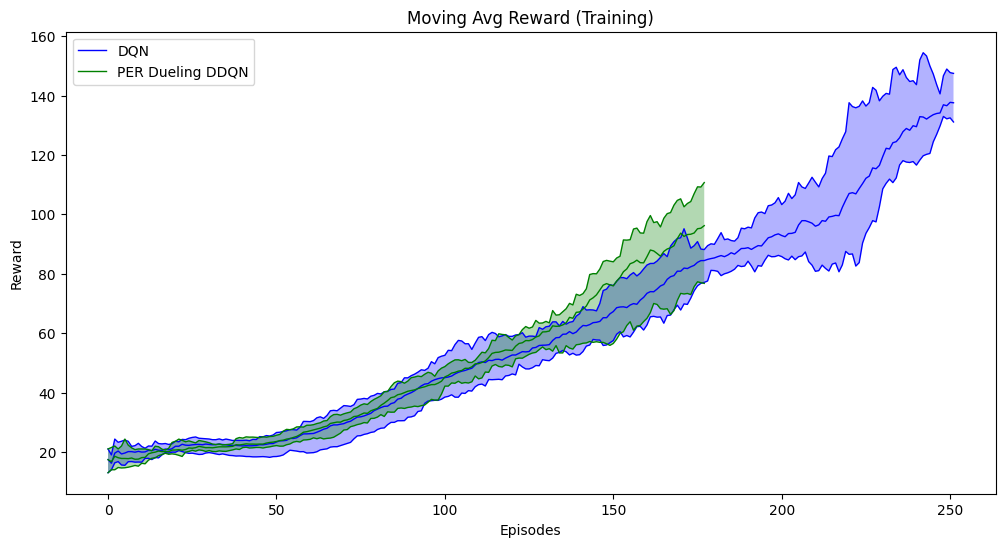

In [69]:
show_result('avg_training_reward','DQN', dqn_results, 'PER Dueling DDQN', per_dueling_ddqn_results) 

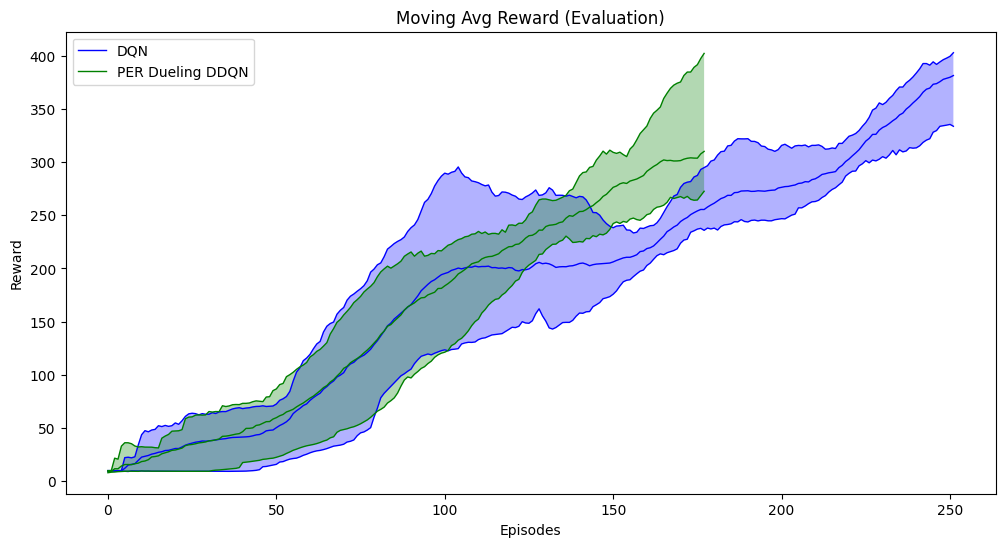

In [70]:
show_result('avg_evaluation_reward','DQN', dqn_results, 'PER Dueling DDQN', per_dueling_ddqn_results) 

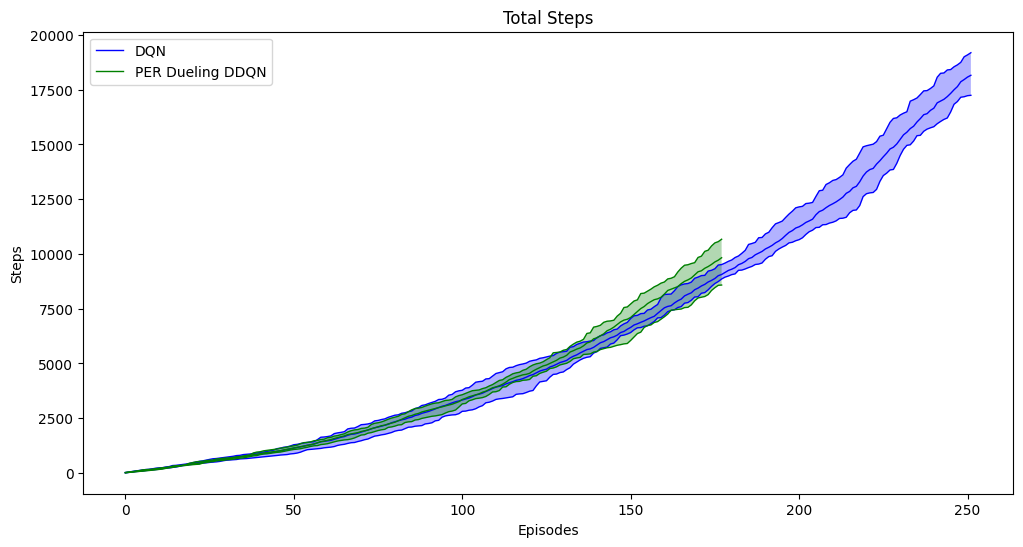

In [71]:
show_result('total_steps','DQN', dqn_results, 'PER Dueling DDQN', per_dueling_ddqn_results) 

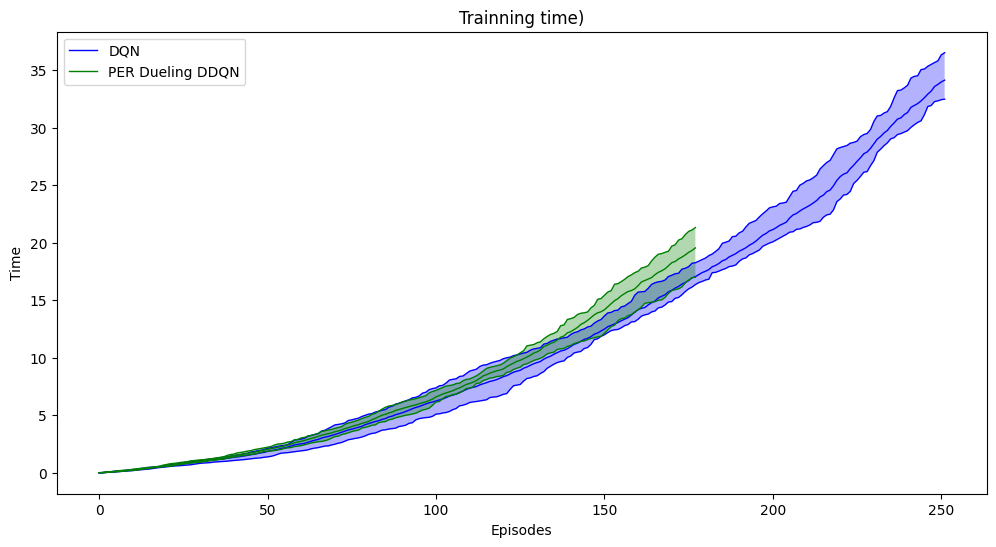

In [72]:
show_result('training_time','DQN', dqn_results, 'PER Dueling DDQN', per_dueling_ddqn_results) 